# Show how storm perturbations affect storm surge.

Read multiple directories containing output from ADCIRC and produced by these NCL scripts
<pre>
/glade/work/ahijevyc/ADCIRC/bulge_timeseries.ncl  
/glade/work/ahijevyc/ADCIRC/perfect_cntl.ncl
</pre>
These directories can hold different speed perturbations, veer perturbations, vmax, or rmax perturbations.


In [1]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
# Embed plots in web page. No floating window.
%matplotlib inline
# svg increases resolution when you zoom in (Ctrl-+); png does not.
# Use svg format (scalable vector graphics) for plots in web page, not png
%config InlineBackend.figure_formats=['png']
dpi = 200
clean = False # clean plots for journal
debug = False
timestamp = not clean # "created by" timestamp in lower-left corner

savfig_dict = {"dpi":dpi, "timestamp": timestamp} 

## USAGE
### Casper

### Import python libraries

In [3]:
from matplotlib import dates
from matplotlib.ticker import NullFormatter, NullLocator# for side histogram
import glob, sys, os, re, urllib.request
from netCDF4 import Dataset, chartostring, num2date
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import atcf
from global_land_mask import globe
import matplotlib.pyplot as plt
from metpy.units import units
#import cf_units # Provision of wrapper class to support UDUNITS-2, netcdftime calendar

#plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'lines.markersize': 8})
from mysavfig import mysavfig
import cache
import pdb

In [4]:
units.kts

<Unit('knot')>

###  Define Storm Class and Perturbation Class

In [5]:
class storm:
    # Each storm is initiated with a name and a domain.
    # and a string describing the control run directory name
    # and possibly a landfall attribute and landfall2 attribute
    
    def __init__(self, name, domain, control_str='control'):
        self.name = name
        # directory containing all the perturbation subdirectories.
        self.basedir = '/glade/work/ahijevyc/ADCIRC/'+name+'/'
        self.domain = domain
        self.control_str = control_str
        
        if name == 'CHARLEY':
            self.landfall = {"time": dt.datetime(2004,8,13,19),
                            "vmax": 130. * units.kts,
                            "mslp": 941. * units.mb
                            }
            self.landfall2 = {"time": dt.datetime(2004,8,13,20),
                            "vmax": 125. * units.kts,
                            "mslp": 942. * units.mb
                            }
        if name == 'HARVEY':
            self.landfall = {"time": dt.datetime(2017,8,26,6),
                            "vmax": 100. * units.kts,
                            "mslp": 950. * units.mb
                            }
        if name == 'IKE':
            self.landfall = {"time": dt.datetime(2008,9,13,7),
                            "vmax":  95. * units.kts,
                            "mslp": 950. * units.mb
                            }
        if name == 'IRMA2017':
            self.landfall = {"time": dt.datetime(2017,9,10,12),
                            "vmax": 115. * units.kts,
                            "mslp": 931. * units.mb
                            }
        if name == 'Michael2018':
            self.landfall = {"time": dt.datetime(2018,10,10,17,30),
                            "vmax": 140. * units.kts,
                            "mslp": 919. * units.mb
                            }



def get_bounds(domain):
    # domain is something like 'stride02.-99.0E-87.0E25.0N31.0N'
    words =  domain.split('.')
    stride = words[0]
    lonmin = float(words[1]+'.'+words[2][0:1])
    lonmax = float(words[2][2:]+'.'+words[3][0:1])
    latmin = float(words[3][2:]+'.'+words[4][0:1])
    latmax = float(words[4][2:]+'.'+words[5][0:1])
    return lonmin, lonmax, latmin, latmax



def landfalls(track, debug=False):
    lfs = pd.DataFrame()
    time0 = track.iloc[0]
    was_land = globe.is_land(time0.lat, time0.lon)
    track = atcf.return_expandedwindradii(track)

    for i in range(0,len(track),4):
        row0 = track.iloc[i].copy()
        # start with r0 line
        for plusrow, t in enumerate(["0","34","50","64"]):
            row = track.iloc[i+plusrow]
            # add a bunch of r34, r50 and r64 columns
            row0[f"r{t}NE"] = row.rad1
            row0[f"r{t}SE"] = row.rad2
            row0[f"r{t}SW"] = row.rad3
            row0[f"r{t}NW"] = row.rad4
        is_land = globe.is_land(row0.lat,row0.lon)
        if not was_land and is_land:
            lfs = lfs.append(row0)
        was_land = is_land
    return lfs



class Perturbation:
    # Called by Perturbations
    def __init__(self, path, storm, Ithresh, minus_astronomical_tide, dryland,
                debug=False):
        
        bpath = os.path.basename(path)
        self.bpath = bpath

        if debug:
            print("initializing Perturbation object")
            print("basename path= "+bpath)
        if 'control' in bpath:
            self.value = bpath
            self.valuelabel = 'control ('+bpath+')'
        elif 'OFCL' in bpath:
            self.value = bpath
            self.valuelabel = 'OFCL ('+bpath+')'
        elif 'ens_' in bpath:
            self.valuelabel = re.findall(r'ens_(\d+)', bpath)[0]
            self.value = int(self.valuelabel)
        elif '.PF' in bpath: # 'ECMWF.0p125.2017090812.PF1'
            self.valuelabel = re.findall(r'.PF(\d+)', bpath)[0]
            self.value = int(self.valuelabel)
        elif '.CF0' in bpath: # 'ECMWF.0p125.2017090812.CF0'
            self.valuelabel = 'CF0'
            self.value = 0
        elif 'WRF' in bpath:
            # value label is number part of .EPS_45.
            # The ensemble member
            self.valuelabel = bpath[19:21]
            self.value = bpath[4:]
        else:
            # Find last index of + or - sign
            n = max([bpath.find('+'), bpath.find('-')])
            if n == -1:
                self.value = re.findall(r'\d+', bpath)[0]
                # good for 2017090600.uni
                if self.value[0:3] == '201':
                    self.value = dt.datetime.strptime(self.value,'%Y%m%d%H')
            else:
                bpath = bpath[n:]
                self.value = float(bpath)
                
        if debug:
            print("value=",self.value)
            print("valuelabel="+self.valuelabel)
        self.path = path
        
        self.timeseries_search_str = path + \
            '/*.minus_astronomical_tide'+str(minus_astronomical_tide)+\
            '_'+Ithresh+'.'+dryland+'.'+storm.domain+'.timeseries.nc'

        self.tsfile = glob.glob(self.timeseries_search_str)
        if len(self.tsfile) == 0:
            print(self.value, "no time series matching "+self.timeseries_search_str, end=" ")
            if debug:
                print("matching", self.timeseries_search_str)
            print()
            return None
        
        if len(self.tsfile) > 1:
            print("Found multiple files matching "+self.timeseries_search_str)
        
        # Fill in these attributes of Perturbation object at time of max Inundation Volume:
        # volume in control zone, length scale, inundation area, average depth
        if debug:
            print(self.tsfile[0])
        fh = Dataset(self.tsfile[0], mode='r')
        inund = fh.variables['inundation_volume'][:]
        imax = np.argmax(inund)
        
        self.max_vol         = inund[imax]
        
        atcf_df = atcf.read(path+"/fort.22")
        self.landfalls = landfalls(atcf_df)
        self.atcf = atcf_df
        

        # True = old way (get value at time of max inundation volume over whole domain)
        self.fixed_time      = False
        if self.fixed_time:
            self.max_vol_in_ctrl = fh.variables['volume_in_ctrl'][imax]
            self.length_scale    = fh.variables['length_scale'][imax]
            self.area            = fh.variables['inundation_area'][imax]
            self.depth           = fh.variables['average_depth'][imax]
        else: 
            # new way (look for max value over all times, not just time of max inundation volume over
            # whole domain)
            # For example, the time with the most water in the ctrl zone is not necessarily the same
            # as the time when the total inundation volume is greatest.
            # Use [:]. or else you sometimes get _FillValue.
            self.max_vol_in_ctrl = np.max(fh.variables['volume_in_ctrl'][:])
            self.length_scale    = np.max(fh.variables['length_scale'][:])
            self.area            = np.max(fh.variables['inundation_area'][:])
            self.depth           = np.max(fh.variables['average_depth'][:])


        self.inund           = inund
        
        # assign time to time attribute
        # use netCDF4-python num2date to convert numbers to datetime objects
        nctimevar = fh.variables['time']
        # Avoid TypeError: float() argument must be a string or a number, not 'cftime._cftime.DatetimeGregorian'
        self.time = num2date(nctimevar[:], nctimevar.units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
        fh.close()

        # if vmax+3, keep +3 part
        if isinstance(self.value,float):
            self.valuelabel = '{0:+g}'.format(self.value)
        # If datetime, keep month/day
        elif isinstance(self.value,dt.datetime):
            self.valuelabel = self.value.strftime('%m/%d')
        #if self.value == 0:
            #self.valuelabel = '' # Uncomment to not include control in legends

        # Also get max water level field. Find node with highest inundation below 6.5 m
        mxfile = path+'/maxele.63.nc'
        Athresh = 6.5

        try:
            fh = Dataset(mxfile, mode='r')
        except:
            if not os.path.exists(mxfile):
                print("maxele.63.nc not in", path)
            if os.path.islink(mxfile) and not os.path.exists(os.readlink(mxfile)):
                print("maxele.63.nc symbolic link broken in", path)
            print("could not read", self.mxfile) 
            self.mxfile = None
            maxele = None
            A = None
            value = None
            lon = None
            lat = None
        else:
            self.mxfile = mxfile
            maxele = fh.variables['zeta_max'][:]
            # Find a node (largest index) with max water height < 6.5m, south of 40°N
            A = np.argmax(maxele * (maxele<Athresh) * (fh.variables['y'][:]<40))
            lon = fh.variables['x'][A]
            lat = fh.variables['y'][A]
            value = maxele[A]

        fh.close()

        self.maxele = maxele
        self.pointA = {"index":A, "value":value, "thresh":Athresh, "lon":lon, "lat":lat}
        print(path)

    def __str__(self):
        return "%s %s" % (self.__class__, self.valuelabel)
    def __repr__(self):
        return "%s(%r)" % (self.__class__, self.bpath)

        
        
class Perturbations:
    
    # Returns an ordered list of perturbation instances in increasing order. 
    
    def __init__(self, storm, ptype, punits="", xlabel="", Ithresh='1.00m', 
                 minus_astronomical_tide=False, dryland='MHHW', debug=False):

        # Map perturbation type to subdirectory name.
        if ptype == 'veers' :
            pstr = 'veer'
            if storm.name == 'HARVEY':
                pstr = 'track'
        elif ptype == 'speeds':
            pstr = 'speed'
        elif ptype == 'vmaxes':
            pstr = 'vmax_PcAdjust'
            if storm.name in ['IRMA2017','HARVEY'] :
                pstr = 'vmax'
        elif ptype == 'rmaxes':
            pstr = 'rmax'
        else:
            print("Unknown perturbation type", name)
            sys.exit(1)
        
        if storm.name in ['IRMA2017','HARVEY']:
            pstr = 'nws19.' + pstr
            
        # find all the directories, scrape off numeric part, sort numerically
        dirnames = glob.glob(storm.basedir+pstr+'[+-]*[0-9]')
        if debug:
            print("Initializing Perturbations instance")
            print("type: "+ptype)
            print("perturbation string: "+pstr)
            print("dirnames:",dirnames)

        self.storm   = storm
        self.ptype   = ptype
        self.units   = punits
        self.Ithresh = Ithresh
        self.minus_astronomical_tide = minus_astronomical_tide

        members = []
        for i in dirnames:
            members.append(Perturbation(i, storm, Ithresh, minus_astronomical_tide, dryland))
            
        self.members  = sorted(members, key=lambda x: x.value, reverse=False)
        self.values          = [i.value for i in self.members]
        self.dirnames        = [i.path for i in self.members]
        self.area            = [i.area for i in self.members]
        self.depth           = [i.depth for i in self.members]
        self.domain          = storm.domain
        self.dryland         = dryland
        self.inund           = [i.inund for i in self.members]
        self.length_scale    = [i.length_scale for i in self.members]
        self.maxele          = [i.maxele for i in self.members]
        self.max_vol_in_ctrl = [i.max_vol_in_ctrl for i in self.members]
        self.max_vol         = [i.max_vol for i in self.members]
        self.mxfile          = [i.mxfile for i in self.members]
        self.pointA          = [i.pointA for i in self.members]
        self.time            = [i.time for i in self.members]
        self.valuelabels     = [i.valuelabel for i in self.members]
        if self.units != "":
            xlabel = " ("+self.units+")"
        self.xlabel          = xlabel
        self.index = 0
        
        # Convert to numpy array
        self.values = np.array(self.values)

        # Get desc from attributes of length_scale variable in control run.
        ifile = storm.basedir + storm.control_str + '/' + storm.control_str + \
            '.minus_astronomical_tide' + str(minus_astronomical_tide) + \
            '_' + Ithresh + '.' + dryland + '.' + storm.domain + '.timeseries.nc'
        if debug:
            print("ifile:"+ifile)
            print("members: ", self.members)

        fh = Dataset(ifile, mode='r')
        ls = fh.variables['length_scale']
        self.desc = pstr + ' minus_astronomical_tide:' +str(minus_astronomical_tide) + \
            " " + dryland + '\ninundation depth threshold: ' + \
            ls.depth_threshold +'\nlength scale left side: ' + \
            str(ls.left_percentile) + '%; right: ' + str(ls.right_percentile) + '%'
        fh.close()

    def __len__(self):
        return len(self.values)
            
    # Allow perturbations to be iterated over
    def __iter__(self):
        return self
    def __next__(self):
        if self.index < len(self.values):
            member = self.members[self.index]
            self.index += 1
            return member
        else:
            self.index = 0
            raise StopIteration
    
    def get_xticks(self):

        # x-axis may be converted from perturbation magnitude to something else.

        # Convert veer perturbations to cross-track distance right of landfall (km)
        # Convert speed perturbations to along-track distance at landfall (km)
        # Keep vmax perturbation (kts)
        # Keep rmax perturbation (%)

        stormname = self.storm.name

        if self.ptype == 'veers':
            if 'IKE' in stormname:
                # From https://docs.google.com/a/ucar.edu/spreadsheets/d/1_Y9dX2240jMZ1abgZt4E6Td-pODq6k3q8rxVKwz55Us/edit?usp=sharing
                pert,dist = np.array([(-6,-250),(-5,-198),(-4,-157),(-3,-121),(-2,-97),(-1,-49),(-0.5,-24),
                                      (0.,0.),(0.5,22),(1.0,44),(2.0,82),(3.0,135),(4.0,146),(5.0,170),
                                      (6.0,199)]).T
            if stormname == 'CHARLEY':
                # https://docs.google.com/a/ucar.edu/spreadsheets/d/1gKj72PWl8g_0QAOCMZawT2c8QRfDa1DreanUWU4DC74/edit?usp=sharing
                # Spreadsheet lists these from +4.5 to -4.5
                pert = [-4.5, -3.5, -2.5, -1.5, -0.5, 0, 0.5, 1.5, 2.5, 3.5, 4.5]
                dist = [-343, -289, -153,  -63,  -15, 0,  32,  63, 102, 122, 134]
            if stormname == 'IRMA2017':
                # https://docs.google.com/a/ucar.edu/spreadsheets/d/1QtxUjO3qIXf2ySPRh0RPG51KasDUCQwmp4ac0hKG3zk/edit?usp=sharing
                # Copied and pasted into vim window and edited to look like this.
                pert,dist = np.array([(-7,-230), (-6,-195), (-5,-181), (-4,-136), (-3,-98), (-2,-63), (-1,-35),
                                  (0,0), (1, 30), (2,60), (3,90), (4,128), (5,158), (6,188), (7,217)]).T
            if stormname == 'HARVEY':
                # https://docs.google.com/spreadsheets/d/1TBdFfGUwdJ9T5Oh7Kv2T7thGvZXeqU1Q_Laj0ztgN4U/edit?usp=sharing
                pert,dist = np.array([(-7,-277.80), (-6,-255.58), (-5,-244.46), (-4,-118.53), (-3 ,-88.90),
                                  (-2,-59.26), (-1,-29.63), (0,0.00), (1,31.48), (2,59.26), (3,96.30),
                                  (4 ,118.53), (5 ,150.01), (6 ,177.79), (7 ,207.42)]).T


        if self.ptype == 'speeds':
            if 'IKE' in stormname:
                # From https://docs.google.com/a/ucar.edu/spreadsheets/d/1_Y9dX2240jMZ1abgZt4E6Td-pODq6k3q8rxVKwz55Us/edit?usp=sharing
                pert,dist = np.array([(-20,-401),(-15,-273),(-10,-173),(-5,-61),(0.,0.),(5,43),
                                      (10,130),(15,248)]).T
            if stormname == 'CHARLEY':
                # From https://docs.google.com/a/ucar.edu/spreadsheets/d/1gKj72PWl8g_0QAOCMZawT2c8QRfDa1DreanUWU4DC74/edit?usp=sharing
                pert = [ -15, -12.5,  -10, -7.5,   -5, -2.5, 0, 2.5,   5, 7.5,  10,  15]
                dist = [-378,  -329, -260, -177, -116,  -35, 0,  94, 163, 220, 275, 348] # km
            if stormname == 'IRMA2017':
                # From https://docs.google.com/a/ucar.edu/spreadsheets/d/1QtxUjO3qIXf2ySPRh0RPG51KasDUCQwmp4ac0hKG3zk/edit?usp=sharing
                # Copied and pasted into vim window and edited to look like this.
                pert,dist = np.array([(-20,-314),(-15,-239), (-10,-159), (-5,-67), (0,0), (5,75), (10,154),
                                      (15,200), (20,236)]).T
            if stormname == 'HARVEY':
                pert,dist = np.array([(-20,-125.936),(-15,-88.896),(-10,-64.82),(-5,-25.928),(0,0),(5,61.116),
                                      (10,120.38),(15,164.828),(20,237.056)]).T


        if self.ptype == 'vmaxes':
            pert,dist = np.array([(-7,-28),(7,28)]).T

        if self.ptype == 'rmaxes':
            # Radius change of +100% error.
            # Find landfall time in control/fort.22
            # Find 34kt line. 
            # Look for max value in columns 35,36,37,38 (in nautical miles)
            # Convert to km.
            # IKE and CHARLEY from Kate Fossell's Feb 28 2017 email
            if stormname ==    'IKE': rmax100 = 75.19 * units.km # km
            if 'CHAR' in stormname:   rmax100 = 36.85 * units.km # km
            if stormname ==   'IRMA2017': rmax100 = 60.93 * units.km # km
            if stormname == 'HARVEY': rmax100 = 44.818 * units.km # km
            pert,dist = list(zip(*[(-100.,-rmax100),(100.,rmax100)]))


        if np.min(pert) >= 0:
            print("no negative perturbations", pert)
            print("did you forget to negate the negative veers and speeds?")
            exit(2)

        xticks = np.interp(self.values, pert, dist)
        return xticks


    # Standard prefix for output filename.
    def oprefix(self, ptype=False):
        p_namestr = ''
        if ptype == True:
            p_namestr = '.' + perturbations.ptype
        prefix =  perturbations.storm.basedir + perturbations.storm.name + \
        p_namestr + \
        '.minus_astronomical_tide' + str(perturbations.minus_astronomical_tide) + \
        '.' + perturbations.Ithresh + '.' + perturbations.domain
        return prefix




### Create storm objects with domains (must have been created by NCL scripts already)

In [6]:
IKE     = storm(name='IKE',     domain='stride10.-99.0E-87.0E25.0N31.0N')
CHARLEY = storm(name="CHARLEY", domain='stride02.-86.0E-78.0E24.2N30.0N')
CHARIKE = storm(name='CHARIKE', domain='stride10.-99.0E-87.0E25.0N31.0N')

init_date = '2018100800'

control_str='nws20.control_newtides_' + init_date
# limited number of inititalizations for control runs
control_str='nws20.control.2018100700'


HARVEY  = storm(name='HARVEY',  domain='stride02.-98.0E-92.2E24.8N30.5N', control_str='nws19.control')

IRMA_SW      = storm(name='IRMA2017', domain='stride01.-88.0E-77.0E24.0N35.0NFloridaSW', control_str=control_str)
IRMA_SWzoom2 = storm(name='IRMA2017', domain='stride02.-83.0E-79.0E24.0N27.0NFloridaSW', control_str=control_str)
IRMA_SWzoom4 = storm(name='IRMA2017', domain='stride02.-82.3E-80.0E24.5N26.1NFloridaSW', control_str=control_str)
IRMA_NEzoom3 = storm(name='IRMA2017', domain='stride02.-82.0E-78.2E30.0N33.0NFloridaNE', control_str=control_str)
IRMA_NE      = storm(name='IRMA2017', domain='stride01.-88.0E-77.0E24.0N35.0NFloridaNE', control_str=control_str)

Michael2018  = storm(name='Michael2018', domain='stride01.-92.0E-82.0E26.0N31.5N', control_str=control_str)


thisstorm = Michael2018


lonmin, lonmax, latmin, latmax = get_bounds(thisstorm.domain)



In [7]:
print(thisstorm.domain)
from collections import OrderedDict
import subprocess
pCexe = "/glade/u/home/fossell/adcirc/kowaleski/printClusters.csh"


def getClusters(init_date, cluster_start_time, cluster_deg, ncluster, members=[], debug=False):
    # maybe use getClusters instead of printClusters
    cluster_id = (init_date,cluster_start_time,cluster_deg,ncluster)
    cyan  = [.13,1,.99]
    green = [.12,1,.16]
    magenta = [1,.11,.99]
    orange = [1,.51,.15]
    red = [.99,.1,.13]
    blue = [.03,0,.98]
    
    cluster_color_dict = {}
    #color that matches Alex's track plots
    if cluster_id == ('2017090512', '2017090512', 5, 7):
        cluster_color_dict = OrderedDict([
            (1, cyan),
            (2, "Black"),
            (3, green),
            (4, magenta),
            (5, orange),
            (6, red),
            (7, blue)
        ])
    if cluster_id == ('2017090512', '2017090912', 3, 6):
        cluster_color_dict = OrderedDict([
            (5, red),     # (a)
            (4, blue),    # (b)
            (2, magenta), # (c)
            (1, cyan),    # (d)
            (6, orange),  # (e)
            (3, green),   # (f)
        ])
    if cluster_id == ('2017090812', '2017090912', 3, 5):
        cluster_color_dict = OrderedDict([
            (3, red),     # (a)
            (5, blue),    # (b)
            (4, magenta), # (c)
            (1, cyan),    # (d)
            (2, orange),  # (e)
        ])
    
    
    if not cluster_color_dict:
        print("bad cluster id", cluster_id)
        set_trace()

    cluster_dict = OrderedDict()
    for i, (cluster, color) in enumerate(cluster_color_dict.items()):    
        iletter = 65+i # chr(65)="A" letter used in Kowaleski et al. paper
        args = [pCexe, init_date, cluster_start_time, str(cluster_deg), str(ncluster), str(cluster)]
        out = subprocess.run(args, check=True, stdout=subprocess.PIPE).stdout.decode()
        # out can have multiple newlines (use replace, then strip)
        # strip takes off trailing newline
        if debug:
            print("input to "+pCexe, args)
            print("output "+out)
        list_of_member_strings = out.replace("\n"," ").strip().split(' ')
        cluster_members = [x for x in members if x.valuelabel in list_of_member_strings]

        # members 33 and 39 blow up
        if init_date == '2017090512':
            for member in cluster_members:
                if member.valuelabel == '33' or member.valuelabel == '39':
                    members.remove(member)

        cluster_dict[cluster] = {"members":cluster_members,"color":color,"letter":chr(iletter)}
        
    return cluster_dict

def get_member_color(cluster_dict, member, debug=False):
    # INPUT:
    # cluster dictionary returned from getClusters()
    # member
    # RETURNS:
    # member's color
    
    if not cluster_dict:
        if debug:
            print("cluster_color_dict is False. Returning Black")
        return "Black"
    for cluster, cdict in cluster_dict:
        members = cdict['members']
        #print cluster, members
        if member.lstrip('0') in members:
            color = cluster_color_dict[cluster]
            if debug:
                print('color for member'+ member, color)
            return color
        else:
            pass
            #print member, 'not in', members
        


stride01.-92.0E-82.0E26.0N31.5N


In [8]:
# functions naturally sort filenames with mixture of strings and integers
 
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


def nice_grid(ax):
    # major and minor ticks, gridlines. 
    ax.grid(b=True, which='major', color='#777777', linestyle='-', linewidth=0.5)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%-m/%-d'))
    ax.xaxis.set_major_locator(dates.HourLocator(byhour=[0]))
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.xaxis.set_minor_locator(dates.HourLocator(byhour=[0,6,12,18]))
    #fig.autofmt_xdate() # make tick labels slanty

## time-lagged MPAS ensemble, or ECMWF, or WRF ensemble  for IRMA2017

In [9]:
ECMWF_ensemble       = False # full grid MET forcing
ECMWF_parameterized_ensemble = True # parameterized storm
MPAS_ensemble        = False
WRF_ensemble         = False
ECMWF_grid_spacing   = False


percentile = False
vmax_from_besttrack = False
besttrack_vmax_at_landfall = False
besttrack_minp_vmax_at_landfall = False
only_EE12 = False
compare_wind_radii_methods = False
OFCL = False

ncluster=1 # used for number of subplot rows (don't use 0)

if thisstorm.name == 'Michael2018':
    estr, tstr = '', ''
    if ECMWF_parameterized_ensemble:
        estr = 'ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.'
        tstr = ''
        basedir_search_str = thisstorm.basedir+estr+init_date+'.[PC]F[0-9]*'
        dirnames = sorted(glob.glob(basedir_search_str), key=natural_keys)
        if len(dirnames) == 0:
            print("zero ECMWF nws20 ensemble dirnames")
            print("basedir_search_str", basedir_search_str)

    if compare_wind_radii_methods:
        estr = 'nws20.control.pretend*'
        tstr = ''
        basedir_search_str = thisstorm.basedir+estr+init_date
        dirnames = sorted(glob.glob(basedir_search_str), key=natural_keys)

    if OFCL:
        estr = 'OFCL.nws20.'
        tstr = ''
        basedir_search_str = thisstorm.basedir+estr+"*"
        dirnames = sorted(glob.glob(basedir_search_str), key=natural_keys)
        
    if only_EE12:
        estr = 'ECMWF.0p125.nws20.origmesh_scale_Vmax.Knaff_Zehr_Pmin.*'
        tstr = 'EE12'
        basedir_search_str = thisstorm.basedir+estr+init_date+'.PF12'
        dirnames = sorted(glob.glob(basedir_search_str), key=natural_keys)
    members_title = estr+tstr + init_date


if thisstorm.name == 'IRMA2017':

    cluster_start_time = '2017090912' # probably '2017090912'
    cluster_deg = 3
    if init_date == '2017090512': ncluster = 6
    if init_date == '2017090812': ncluster = 5

    if ECMWF_parameterized_ensemble:
        estr = 'ECMWF.0p125.nws19.'
        tstr = ''
        if percentile:
            estr += '90percentile.'
            tstr = '\n90th percentile ' # space at end
        if vmax_from_besttrack:
            estr += 'vmax_from_besttrack.'
            tstr = '\nvmax from best track ' # space at end
        if besttrack_vmax_at_landfall:
            estr += 'besttrack_vmax_at_25.2N.'
            tstr = '\nbesttrack vmax at 25.2N '
        if besttrack_minp_vmax_at_landfall:
            estr += 'besttrack_minp_vmax_at_25.2N.'
            tstr = '\nbesttrack minp vmax at 25.2N '
        basedir_search_str = thisstorm.basedir+estr+init_date+'.[PC]F[0-9]*'
        dirnames = sorted(glob.glob(basedir_search_str), key=natural_keys)
        #dirnames = dirnames[22:] # HACK - only ran members 1-22 to keep MMM under 100% 30-day utilization
        if len(dirnames) == 0:
            print("zero ECMWF nws19 ensemble dirnames")
            print("basedir_search_str", basedir_search_str)
        members_title = "ECMWF ensemble 0p125 nws19 "+tstr + init_date
    
    if MPAS_ensemble:
        members_title = "MPAS uniform 15km mesh, ECMWF init. conditions"
    if WRF_ensemble:
        # Previously, I changed '??' to [0-9][0-9] to avoid matching 'CO'. Wanted to match 51, which was symbolic linked to 'CO'
        # as of Dec 16 2019, removed reference to member 51 in directory structure and printCluster.csh output.
        # So search for [0-9C][0-9O] instead of [0-9][0-9]
        search_pattern = thisstorm.basedir+'WRF.' + init_date + '.EPS_[0-9C][0-9O]*.27km3km'
        print('search pattern:', search_pattern)
        dirnames = sorted(glob.glob(search_pattern))

        if init_date == '2017090512':
            # runs that blow up
            dirnames.remove('/glade/work/ahijevyc/ADCIRC/IRMA/WRF.2017090512.EPS_33.27km3km')
            dirnames.remove('/glade/work/ahijevyc/ADCIRC/IRMA/WRF.2017090512.EPS_39.27km3km')

        members_title = 'WRF ' + init_date + ' EPS 27km3km'

        
if ECMWF_grid_spacing:
    dirnames = sorted(glob.glob(thisstorm.basedir+'ECMWF.0p*'+init_date+'.ens_48'),
                     key=natural_keys)
    members_title = " ".join(["ECMWF ensemble grid spacing", init_date, "member 48"])


if ECMWF_ensemble:
    basedir_search_str = thisstorm.basedir+'ECMWF.0p125.'+init_date+'.[PC]F[0-9]*'
    dirnames = sorted(glob.glob(basedir_search_str), key=natural_keys)
    if len(dirnames) == 0:
        print("ECMWF ensemble basedir: "+ basedir_search_str)
        print("ECMWF ensemble dirnames=", dirnames)
    members_title = "ECMWF ensemble 0p125 " + init_date
    only_these = ["10","14","20","31","44","47"]
    only_these = []
    dirnames = ['/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.2018100800.PF'+x for x in only_these]
    print(dirnames)
    #dirnames.remove('/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.2018100812.PF02')
    #dirnames.remove('/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.2018100812.PF12')
    #dirnames.remove('/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.2018100812.PF25')


        
members_title_keep = members_title
Ithresh = '1.00m'
minus_astronomical_tide = False
dryland  = 'MHHW'

# Start list of members with control 
members = [Perturbation(thisstorm.basedir+thisstorm.control_str, thisstorm, Ithresh, 
                        minus_astronomical_tide, dryland, debug=debug)]
# or don't start with control
#members = []

for dirname in dirnames:        
    members.append(Perturbation(dirname, thisstorm, Ithresh, minus_astronomical_tide, dryland, debug=debug))

    
# Remove members with no time series data.
members = [x for x in members if hasattr(x, "max_vol")]
    
dirnames        = [i.path for i in members]
area            = [i.area for i in members]
depth           = [i.depth for i in members]
inund           = [i.inund for i in members]
length_scale    = [i.length_scale for i in members]
maxele          = [i.maxele for i in members]
max_vol_in_ctrl = [i.max_vol_in_ctrl for i in members]
max_vol         = [i.max_vol for i in members]
mxfile          = [i.mxfile for i in members]
pointA          = [i.pointA for i in members]
time            = [i.time for i in members]
valuelabels     = [i.value for i in members]


/glade/work/ahijevyc/ADCIRC/Michael2018/nws20.control.2018100700


/glade/work/ahijevyc/20200417_dav_daa/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF01
/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF02
/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF03
/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF04
/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF05
/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF06
/glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r

### Time series of inundation volume
could be from special time-lagged IRMA2017 ensemble by MPAS<br>
could be ECMWF ensemble<BR>
could be WRF ensemble from Alex K. 

cluster members[<class '__main__.Perturbation'>('nws20.control.2018100700'), <class '__main__.Perturbation'>('ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF01'), <class '__main__.Perturbation'>('ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF02'), <class '__main__.Perturbation'>('ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF03'), <class '__main__.Perturbation'>('ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF04'), <class '__main__.Perturbation'>('ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF05'), <class '__main__.Perturbation'>('ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.PF06'), <class '__main__.Perturbation'>('ECMWF.0p125.nws20.bt.origmesh.scaled_v

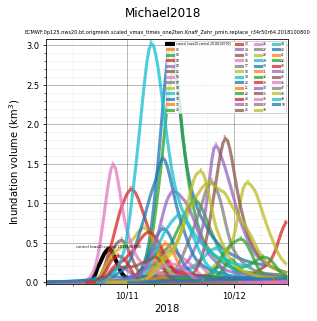

In [260]:
# Ensure variable is defined
try:
    members
except NameError:
    members = None

# avoid this FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. 
# The converter was registered by pandas on import. 
# Future versions of pandas will require you to explicitly register matplotlib converters.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

do_clusters = False

if do_clusters and WRF_ensemble:
    clusters = getClusters(init_date, cluster_start_time, cluster_deg, ncluster, members=members, debug=True)
else:
    # Merge clusters into a dictionary with single key 'all' 
    # (for non-cluster stuff like ECMWF ensemble)
    clusters = {'all': {'members': members, 'color':'black', 'letter':'a'}}

clean = clean # fewer symbols along lines
sideHistogram = False # histogram of maxima on right
npanel = ncluster
ncols = 2
allOnePanel = not do_clusters
if allOnePanel:
    npanel = 1
    ncols  = 1
nrows = int(np.ceil(npanel/ncols))
border = 1.0
figsize = (ncols*10./3.+border,nrows*7./2.+border)
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=figsize, 
                       squeeze=False, sharex=True, sharey=True) # squeeze=False returns 2D array not scalar
plt.subplots_adjust(wspace = 0.1, hspace= 0.1)

nullfmt = NullFormatter() # no labels for side histogram
noticks = NullLocator()

members_title = members_title_keep
fineprint = ""
for iax, (cluster, cdict) in enumerate(clusters.items()):
    if not allOnePanel:
        tsaxes = ax.flat[iax]
    else:
        tsaxes = ax.flat[0]
    
    tsaxes.tick_params(axis='both', which='major', labelsize='small')
    if sideHistogram:
        pos = tsaxes.get_position()
        rect_histy = [pos.xmax + 0.025, pos.ymin, 0.05, pos.height]
        axHisty = plt.axes(rect_histy)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHisty.set_title('maxima\nhistogram', fontdict={'fontsize':'xx-small'})
        axHisty.tick_params(axis='both', which='major', labelsize='xx-small')

    maxima = []
    # Only Alex K's WRF ensemble deals with clusters
    color = 'black'
    color=None
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    if WRF_ensemble:
        cluster_str = str(cluster)
        if allOnePanel:
            cluster_str = "all"
        cluster_id = ' '.join([
            init_date,
            cluster_start_time,
            str(cluster_deg),
            str(ncluster),
            cluster_str
        ])
        members_title = members_title_keep.replace('EPS','EPS cluster'+cluster_id)
        if do_clusters:
            color = cdict['color']
        else:
            color="gray"
        cluster_members = cdict['members'] # TODO 
        
    elif MPAS_ensemble or ECMWF_ensemble or ECMWF_parameterized_ensemble or ECMWF_grid_spacing:
        cluster_id = "none"
        # list of strings of numbers 1 - len(members)
        cluster_members = members
    else:
        print("unknown ensemble")
        set_trace()
        
    if members:
        print("cluster members" + str(cluster_members))
        sayhiding = True
        
        landfall_dict = {}

        for pert in members:
            if only_EE12:
                pert.valuelabel = pert.bpath.replace("ECMWF.0p125.nws20.origmesh_", "")
            label = pert.valuelabel
            line, = tsaxes.plot(pert.time,pert.inund,label=label,markersize=3,lw=3.1)
            
            
            
            if isinstance(pert.value, int):
                # useful when some members are missing.
                # This will keep the color of a particular member constant
                # no matter its order
                color = colors[pert.value % len(colors)] # skip to nth color

            print(pert, color)
            if False and color: # force color of a member number to be consistent 
                line.set_color(color)


            line.set_alpha(0.75)

            # label/star top of line
            top_of_line = np.max(pert.inund)
            maxima.append(top_of_line)
        
            if clean:
                # just put a star
                topoflinelabel, = tsaxes.plot(pert.time[np.argmax(pert.inund)], top_of_line, 'k*',
                                             markeredgewidth=0.1)
            else:
                # instead of a star, put valuelabel (e.g. member number)
                topoflinelabel = tsaxes.annotate(pert.valuelabel,
                    xy=(pert.time[np.argmax(pert.inund)], top_of_line), xycoords='data',
                    xytext=(0, 0), textcoords='offset points', fontsize=3.5, color=line.get_color(),
                    horizontalalignment='center', verticalalignment='bottom')


            if isinstance(pert.value, str) and 'control' in pert.value:
                line.set_linewidth(4)
                line.set_color('k')
                line.set_alpha(1)
                topoflinelabel.set_color('k')
                # Remove this maximum from maxima list
                maxima.remove(top_of_line)
                if sideHistogram:
                    hline = axHisty.axhline(top_of_line)
                    hline.set_linewidth(line.get_linewidth())
                    hline.set_color(line.get_color())
                fineprint += 'control='+thisstorm.control_str
            elif isinstance(pert.value, dt.datetime):
                if pert.value > dt.datetime(2017,9,7):
                    line.set_marker('o')
                    line.set_markevery(1)
            elif isinstance(pert.value, int):
                markers=False
                if markers:
                    markers = ['','o','^','s','x']
                    line.set_marker(markers[int((pert.value-1)/10)])
                    line.set_markevery(12)


            # Make non-member lines invisible
            # Deal with string numbers that may be zero-padded and 'CO'
            # strip zero-pad before comparing
            # Is there a less error-prone way to compare?
            if pert.valuelabel not in [x.valuelabel for x in cluster_members]:
                if sayhiding:
                    print('hiding', end=" ")
                sayhiding = False
                print(pert.valuelabel, end=" ")
                line.set_visible(False)
                topoflinelabel.set_visible(False)
            else:
                if not sayhiding:
                    print("\n")
                print(pert.valuelabel, pert.time[np.argmax(pert.inund)], top_of_line, end="")
                maxinund = {'time of max inundation volume': pert.time[np.argmax(pert.inund)],
                            'max inundation volume' : top_of_line,
                            'max vmax' : pert.atcf.vmax.max()}
                landfall_dict[pert.value] = maxinund
                if not pert.landfalls.empty:
                    first_landfall = pert.landfalls.iloc[0]
                    landfall_dict[pert.value] = {**maxinund, **first_landfall.to_dict()}

                sayhiding = True
            
        ylabel = 'Inundation volume ($\mathregular{km^3}$)'
        tsaxes.set_ylabel(ylabel)

        nice_grid(tsaxes)# major and minor ticks, gridlines. 


        tsaxes.set_xlabel(members[0].time[0].strftime("%Y"))

        if not clean: # used to have not allOnePanel too
            # put legend
            if len(members) > 10:
                tsaxes.legend(loc='best', fontsize=3, ncol=4)
            else:
                tsaxes.legend(loc='best', fontsize=4)

            plt.suptitle(thisstorm.name)
            tsaxes.set_title(members_title, fontsize=5)
        else:
            if do_clusters:
                panel_letter = chr(iax+97)
                if cdict['letter'].upper() != panel_letter.upper():
                    print("cluster letter doesn't match expectations")
                    pdb.set_trace()
                panel_str = '('+panel_letter+')'
                tsaxes.annotate(panel_str, (0.01, 0.98), xycoords='axes fraction',
                               fontsize=28, verticalalignment='top')
        
        # force 2017090812 and 2017090512 to same limits
        print(tsaxes.get_xlim())
        print(tsaxes.get_ylim())
        if thisstorm.domain == 'stride01.-92.0E-82.0E26.0N31.5N':
            tsaxes.set_xlim(736977.25, 736979.5)
            tsaxes.set_ylim((-0.02, 3.08))
        if thisstorm.domain == 'stride01.-88.0E-77.0E24.0N35.0NFloridaNE':
            tsaxes.set_xlim((736581., 736585.))
            tsaxes.set_ylim((-0.14114182363104172, 4.958379911452546))
        if thisstorm.domain == 'stride01.-88.0E-77.0E24.0N35.0NFloridaSW':
            tsaxes.set_xlim((736581., 736585.))
            tsaxes.set_ylim((-0.14205421008031377, 4.6))
            if WRF_ensemble: tsaxes.set_ylim((-0.14205421008031377, 3.))



        # Add side histogram. Do this after main axes limits are settled.
        if sideHistogram:
            count, bins, patches = axHisty.hist(maxima, orientation='horizontal')
            axHisty.set_ylim(tsaxes.get_ylim())



for i in ax.flat:
    i.label_outer()
            
# Hide axes we don't need
if clean and ncluster % 2 != 0 and len(ax.flat) > 1:
    ax[-1,-1].axis('off')
    # restore xtick labels to right column.
    ax[-2,-1].xaxis.set_tick_params(labelbottom=True)


fineprint += "\ncluster " + cluster_id +"\n"+" ".join(["ensemble", thisstorm.domain])
if clean:fineprint = ""
status = mysavfig(thisstorm.basedir+members_title.replace(' ','_').replace('\n','.') + '.' 
                  + thisstorm.domain + '.timeseries.png', 
                  string = fineprint, 
                  **savfig_dict )
        

In [261]:
oxl = thisstorm.basedir+members_title.replace(' ','_').replace('\n','.') + '.' + thisstorm.domain+".xlsx"
pd.DataFrame.from_dict(landfall_dict,orient='index')[
    ["max vmax", "time of max inundation volume", "max inundation volume", "valid_time","lon","lat","vmax",
     "r34NE","r34SE","r34SW","r34NW",
     "r50NE","r50SE","r50SW","r50NW",
     "r64NE","r64SE","r64SW","r64NW"]
].to_excel(oxl, sheet_name=init_date)
print("created", oxl)

created /glade/work/ahijevyc/ADCIRC/Michael2018/ECMWF.0p125.nws20.bt.origmesh.scaled_vmax_times_one2ten.Knaff_Zehr_pmin.replace_r34r50r64.2018100800.stride01.-92.0E-82.0E26.0N31.5N.xlsx


In [176]:
landfall_dict

{'nws20.control.2018100700': {'time of max inundation volume': datetime.datetime(2018, 10, 10, 20, 0),
  'max inundation volume': 0.42369990769445864,
  'max vmax': 135},
 1: {'time of max inundation volume': datetime.datetime(2018, 10, 10, 21, 30),
  'max inundation volume': 0.3580593685421667,
  'max vmax': 105},
 2: {'time of max inundation volume': datetime.datetime(2018, 10, 10, 22, 0),
  'max inundation volume': 0.4389806613323629,
  'max vmax': 116},
 3: {'time of max inundation volume': datetime.datetime(2018, 10, 10, 22, 0),
  'max inundation volume': 0.7198076236717423,
  'max vmax': 105},
 4: {'time of max inundation volume': datetime.datetime(2018, 10, 11, 0, 0),
  'max inundation volume': 0.512298109379572,
  'max vmax': 105},
 5: {'time of max inundation volume': datetime.datetime(2018, 10, 11, 1, 30),
  'max inundation volume': 1.616112838575119,
  'max vmax': 123},
 6: {'time of max inundation volume': datetime.datetime(2018, 10, 10, 23, 0),
  'max inundation volume': 0

In [135]:
Perturbation(thisstorm.basedir+thisstorm.control_str, thisstorm, Ithresh, minus_astronomical_tide, dryland)
[x.value for x in members]

/glade/work/ahijevyc/ADCIRC/Michael2018/nws20.control.2018100700


['nws20.control.2018100700',
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [136]:
allOnePanel

True

### Define map_points() for Basemap plots

In [20]:

import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import gridlines


def map_point(ax, lon, lat, scalebuffer=1., label=None, debug=False, **kwargs):
    # Ported map_points from basemap to cartopy"
    # Scatter plot on a map.
    # Domain large enough to encompasses all the markers, plus a 3° longitude and 1° latitude buffer. 

    extent = (np.amin(lon)-3.*scalebuffer,np.amax(lon)+3.*scalebuffer,np.amin(lat)-1.*scalebuffer,np.amax(lat)+1.*scalebuffer)
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), linewidth=0.35, alpha=0.55)
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('10m'), linewidth=0.5, alpha=0.55)
    
    ax.plot(lon, lat, 'ko', **kwargs)

    if label:
        ax.text(lon, lat, label,  ha='center', va='center', fontsize=5.)

    return



def map_track(ax, trackfile, color='black', debug=False, **kwargs):
    # Ported map_track from basemap to cartopy

    #if debug:
    #    print("map_track: genfromtxt() with "+trackfile)
    #lat0, lon0 = np.genfromtxt(trackfile,delimiter=',', usecols=(6,7),dtype=None, unpack=True, encoding="utf-8")
    #lat0 = [int(i[:-1])/10. for i in lat0]
    #lon0 = [int(i[:-1])/ -10. for i in lon0]
    
    dat = atcf.read_atcf(trackfile)
    lon0 = dat.lon
    lat0 = dat.lat
    track = ax.plot(lon0, lat0, color=color, label=trackfile[70:74], **kwargs)
    return track

    
    

def forecast_err_box(xmin, xmax, label, **kwargs):
    # Called by forecast_err_boxes()
    # Draw box from xmin to xmax, spanning the vertical.
    # Label vertical lines too.
    ax = kwargs['axes']
    # Dont' change the xaxis range
    ax.autoscale(False)
    box = ax.axvspan(xmin, xmax, alpha=0.075, facecolor='red', **kwargs)
    edgecolor = 'red'
    box = ax.axvspan(xmin, xmax, alpha=0.2, facecolor="none", edgecolor=edgecolor, lw=1.8, **kwargs)
    labelL = ax.annotate(s=label, xy=(xmin,0.5), ha="center", va="center", xycoords=('data', 'axes fraction'), 
                         rotation=90, fontsize=12, annotation_clip=True, zorder=1, alpha=0.75, **kwargs)
    labelR = ax.annotate(s=label, xy=(xmax,0.5), ha="center", va="center", xycoords=('data','axes fraction'), 
                         rotation=90, fontsize=12, annotation_clip=True, zorder=1, alpha=0.75, **kwargs)

def forecast_err_boxes(ax, perturbation):
    # Draw tranparent red boxes to illustrate typical forecast err for different lead times.

    if perturbation.ptype == 'veers':
        # list of (hour, nautical miles) tuples to define 2010-2014 cone from 
        # https://docs.google.com/a/ucar.edu/spreadsheets/d/1_Y9dX2240jMZ1abgZt4E6Td-pODq6k3q8rxVKwz55Us/edit?usp=sharing
        fhr, radii = list(zip(*[(12,32),(24,52),(36,71),(48,90),(72,122),(96,170),(120,225)]))
        
        # Convert nautical miles to km
        radii = units["nautical miles"] * radii
        radii = radii.to('km')
        fhrboxes = [12,24,48,72]

    if perturbation.ptype == 'speeds':
        # list of (hour, km) tuples to define 2010-2014 cone estimated to be more than cross-track error from
        # https://docs.google.com/a/ucar.edu/spreadsheets/d/1_Y9dX2240jMZ1abgZt4E6Td-pODq6k3q8rxVKwz55Us/edit?usp=sharing
        fhr, radii = list(zip(*[(12,32),(24,52),(36,71),(48,90),(72,122),(96,170),(120,225)]))

        # Convert nautical miles to km
        radii = units["nautical miles"] * radii
        radii = radii.to('km')

        fhrboxes = [12,24,48,72]

    if perturbation.ptype == 'vmaxes':
        # list of (hour, knots) tuples from NHC published stats 
        # https://drive.google.com/open?id=0B4GoIuq38OVyLTRhTkxmbE1YZVY1eU5xYlA3RlJWOHlyN3A0
        fhr, radii = list(zip(*[(24,10),(48,15),(72,20)]))
        fhrboxes = fhr
        
    if perturbation.ptype == 'rmaxes':
        # list of (hour, km) tuples Feb 10 2017 email from Kate Fossell
        # Based on Cangialosi and Landsea (2016)
        fhr, radii = list(zip(*[(12,37),(24,52),(36,60),(48,63),(72,68)]))
        fhrboxes = [12,24,48,72]
        
    try:
        fhr
    except NameError:
        print("no foreast lead time window for", perturbation.name, perturbation.storm.name)
        return
    # np.interp(x,xp,fp)
    # x: x-coordinates of interpolated values
    # xp: 1-D seq of floats. the x-coordinates of the data points
    # fp: 1-D seq of floats or complex. The y-coordinates of the data points, same len as xp.
    # Get errors assocated with fboxes list.
    lefts = -np.interp(fhrboxes, fhr, radii)
    rights = np.interp(fhrboxes, fhr, radii)
    for box, left, right in zip(fhrboxes, lefts, rights):
        junk = forecast_err_box(left, right, '%d-hr' % box, axes=ax)
        
def zeroLine(line, **kwargs):
    line.axes.axvline(x=0, linestyle='dashed', color='black', zorder=1)
    # Use np.isclose because of rmaxes, where zero tick is interpolated to a tiny non-zero value.
    i0, = np.where(np.isclose(line.get_xdata(), 0))
    line.axes.axhline(y=line.get_ydata()[i0], linestyle='dashed', color=line.get_color(), **kwargs)
            
def annotate_pts(perturbation, line):
    for label, xypoints in zip(perturbation.valuelabels, line.get_xydata()):
        line.axes.annotate(label, xy=xypoints, textcoords='offset points', xytext=(0,+4), 
                           ha='center', va='bottom', fontsize=6.5)

        


### Compare Best Track run to NOAA Stations (IKE or IRMA2017 )

In [13]:
# NOAA station data come from tidesandcurrents.noaa.gov
def turl(station_id, begin_date, end_date, datum):
    url = "https://tidesandcurrents.noaa.gov"
    
    search_string = "/api/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&station="+\
        station_id+"&begin_date="+begin_date+"&end_date="+end_date+"&datum="+datum+\
        "&units=metric&time_zone=GMT&format=csv"

    return url + search_string

In [14]:
import pandas as pd
from netCDF4 import MFDataset
import xarray


datums = {}
# can get directly from tidesandcurrents.noaa.gov with cell below
# meters relative to MLLW
#datums['8665530'] = {'MHHW': 1.757, 'NAVD88': 0.957, 'name':'Charleston, Cooper River Entrance, SC'}
#datums['8670674'] = {'MHHW': 0.000, 'NAVD88': 0.000, 'name':'Talmadge Memorial Bridge, GA'}
#datums['8670870'] = {'MHHW': 2.287, 'NAVD88': 1.235, 'name':'Fort Pulaski, GA'}
#datums['8720030'] = {'MHHW': 1.999, 'NAVD88': 1.165, 'name':'Fernandina Beach, FL'}
#datums['8722956'] = {'MHHW': 0.857, 'NAVD88': 0.694, 'name':'South Port Everglades, FL'}
#datums['8723214'] = {'MHHW': 0.676, 'NAVD88': 0.614, 'name':'Virginia Key, Biscayne Bay, FL'}
#datums['8723970'] = {'MHHW': 0.297, 'NAVD88': 0.407, 'name':'Vaca Key, Florida Bay, FL'}
#datums['8724580'] = {'MHHW': 0.551, 'NAVD88': 0.538, 'name':'Key West, FL'}
#datums['8725110'] = {'MHHW': 0.874, 'NAVD88': 0.690, 'name':'Naples, Gulf Of Mexico FL'}
#datums['8726667'] = {'MHHW': 0.817, 'NAVD88': 0.514, 'name':'Mckay Bay Entrance, FL'}
datums['8727520'] = {'MHHW': 1.158, 'NAVD88': 0.687, 'name':'Cedar Key, FL'}
datums['8728690'] = {'MHHW': 0.492, 'NAVD88': 0.232, 'name':'Apalachicola, FL'}
datums['8729108'] = {'MHHW': 0.409, 'NAVD88': 0.170, 'name':'Panama City, FL'}
datums['8729210'] = {'MHHW': 0.425, 'NAVD88': 0.162, 'name':'Panama City Beach, FL'}
datums['8729840'] = {'MHHW': 0.383, 'NAVD88': 0.098, 'name':'Pensacola, FL'} # not in fort.61
#datums['8732828'] = {'MHHW': 0.490, 'NAVD88': None, 'name':'Weeks Bay, Mobile Bay, AL'}
datums['8735180'] = {'MHHW': 0.371, 'NAVD88': 0.158, 'name':'Dauphin Island, AL'}
#datums['8735391'] = {'MHHW': 0.500, 'NAVD88': None, 'name':'Dog River Bridge, AL'}
datums['8737048'] = {'MHHW': 0.502, 'NAVD88': 0.149, 'name':'Mobile State Docks, AL'}




def to_MHHW(cluster_zeta, debug=False):
    # cluster_zeta is an xarray DataArray
    MHHW_long_name = 'mean higher-high water'
    if cluster_zeta.attrs['long_name'] == MHHW_long_name:
        if debug:
            print("to_MHHW: cluster_zeta already in MHHW. returning unchanged")
        return cluster_zeta
    
    station_id = str(cluster_zeta.station.values)
    if cluster_zeta.attrs['long_name'] != "water surface elevation above geoid":
        print("unexpected long_name "+cluster_zeta.long_name)
        sys.exit(1)
    if cluster_zeta.attrs['standard_name'] != "sea_surface_height_above_geoid":
        print("unexpected standard_name "+cluster_zeta.standard_name)
        sys.exit(1)
    if cluster_zeta.attrs['units'] != "m":
        print("unexpected units "+cluster_zeta.units)
        sys.exit(1)
        
    if debug:
        print("to_MHHW: converting "+station_id+" to MHHW")

    # Adding NAVD88 converts from NAVD88 to MLLW
    # subtracting MHHW converts from MLLW to MHHW
    try:
        NAVD88 = datums[station_id]['NAVD88']
        MHHW   = datums[station_id]['MHHW']
    except KeyError:
        print("no hard-coded datum for station "+station_id+". We have")
        print(datums)
        print("copy and paste from tidesandcurrents.noaa.gov")
        sys.exit(1)
    if NAVD88 is None:
        print(datums[name], "No NAVD88 datum. Can't derive height relative to MHHW")
        sys.exit(1)
    cluster_zeta.values = cluster_zeta.values + NAVD88 - MHHW
    cluster_zeta.attrs['long_name'] = 'mean higher-high water'
    cluster_zeta.attrs['standard_name'] = 'MHHW'
    return cluster_zeta

In [15]:
cdict

{'members': [<class '__main__.Perturbation'>('nws20.control.2018100812')],
 'color': 'black',
 'letter': 'a'}

In [18]:
import requests
import lxml.html as lh
import pandas as pd
# NOAA station data come from tidesandcurrents.noaa.gov
def durl(station_id, datum):
    url = "https://tidesandcurrents.noaa.gov"
    search_string = "/datums.html?datum="+datum+"&units=1&epoch=0&id="+str(station_id)
    return url + search_string

station_ids = [8727520, 8728690, 8729108, 8729210, 8729840, 8732828]
datum = "MLLW"

for station_id in station_ids:
    print(station_id, end=" ")
    #Create a handle, page, to handle the contents of the website
    page = requests.get(durl(station_id, datum))


    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)
    tbodys = doc.xpath('//tbody')
    table = tbodys[0] # assume we want the first tbody.
    tr_elements = table.getchildren()
    for T in tr_elements:
        tds = T.getchildren()
        if tds[0].text_content() == "MHHW":
            print(tds[0].text_content(), tds[1].text_content(), end=" ")
        if tds[0].text_content() == "NAVD88":
            print(tds[0].text_content(), tds[1].text_content())


8727520 MHHW 1.158 NAVD88 0.687
8728690 MHHW 0.492 NAVD88 0.232
8729108 MHHW 0.409 NAVD88 0.170
8729210 MHHW 0.425 NAVD88 0.162
8729840 MHHW 0.383 NAVD88 0.098
8732828 MHHW 0.490 NAVD88 


In [19]:
do_clusters = False # this is also defined much further above
debug=False
draw_map = debug or True # draw map


# Get stations, lat/lon, time, and zeta from first model file
first_model_file = members[0].path + "/fort.61.nc"
ds = xarray.open_dataset(first_model_file)
if debug:
    print('first model file', first_model_file)

# Minimum time in station file plus an optional offset 
# Avoid utype error by converting to numpy and converting to datetime.
begin_date = pd.to_datetime(ds.time.values.min()) + dt.timedelta(hours=0)
begin_yyyymmdd = begin_date.strftime('%Y%m%d')
# Don't do offset from ds.time.min(). There are different initialization times
#begin_date = '20170909' # for IRMA2017
end_date = pd.to_datetime(ds.time.values.max()) + dt.timedelta(hours=24) # must be multiple of days
end_yyyymmdd = end_date.strftime('%Y%m%d')
#end_date = '20170913' # for IRMA2017


# make the array of station names the coordinate variable for station dimension
station = [ x.values.tostring().decode(encoding="utf-8").strip() for x in ds.station_name]
ds = ds.assign_coords(station = station)


#units = cf_units.Unit(ds.zeta.units)
#long_name = ds.zeta.long_name
ds.close()

# add zeta from other model files (if any)
if debug: print("concat'ing",end=" ")
for member in members[1:]: # skip index 0. we already read 1st member
    station_file = member.path+"/fort.61.nc"
    if debug:
        print(os.path.basename(station_file), end=' ')

    member = member.valuelabel
    print("(member "+member+")")
    ds1 = xarray.open_dataset(station_file)
    ds = xarray.concat([ds,ds1], dim="member") 
    ds1.close()


print(ds.zeta.shape)

member_labels = [x.valuelabel for x in members]
ds = ds.assign_coords(member = member_labels)

# truncate to time axis extent, so max() function won't find time outside of time axis
ds = ds.sel(time=slice(begin_date, end_date))

if debug:
    print(member_labels)
    print(ds)

opener = urllib.request.build_opener(cache.CacheHandler(".urllib2cache"))

ncols = 2
nrows = ncluster
figsize=(11,ncluster*4)
if clean:
    nrows = int(np.ceil(ncluster/ncols))
    figsize=(10,4*nrows)

if draw_map:
    fig = plt.figure(figsize=figsize)
    plt.gcf().subplots_adjust(bottom=0.17)
else:      
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
    plt.subplots_adjust(wspace = 0.1, hspace= 0.1)

fineprint_obj = plt.annotate(s="", xy=(2,0), xycoords=('figure pixels','axes fraction'), va="bottom", fontsize=4)
cols = pd.MultiIndex.from_product([("prob","max","meanmax","minmax"),["a"]],names=["","cluster letter"])
qtable = pd.DataFrame(columns=cols)

for station in ds.station:
    station_id = str(station.values)
    if station_id not in datums.keys(): # for alex's paper
        if debug:
            print(station_id, 'not in datums dict', end=" ")
        continue
        
    qtable.loc[station_id,"name"] = datums[station_id]['name']

    # station latitude and longitude
    slon = ds.x.sel(station=station).values.mean() # values should be a scalar or all the same
    slat = ds.y.sel(station=station).values.mean()

    if ((slon < lonmin) | (slon > lonmax) | (slat < latmin) | (slat > latmax)):
        if debug:
            print(station_id+ ' out of bounds')
        continue

    datumObs = 'NAVD'
    datumObs = 'MHHW'

    df = pd.read_csv(turl(station_id,begin_yyyymmdd,end_yyyymmdd,datumObs))
    if 'Date Time' not in list(df.keys()):
        print(df, turl(station_id,begin_yyyymmdd,end_yyyymmdd,datumObs))
        print('failed to read', station_id, begin_yyyymmdd, end_yyyymmdd, datumObs,'trying MSL')
        datumObs = 'MSL'
        df = pd.read_csv(turl(station_id,begin_yyyymmdd,end_yyyymmdd,datumObs))
        if 'Date Time' not in list(df.keys()):
            print(df)
            print('failed to read', station_id, begin_yyyymmdd, end_yyyymmdd, datumObs, 'skipping')
            continue


    # strip left and right whitespace from column names
    df.rename(columns=lambda x: x.strip(), inplace=True)

    if isinstance(df['Date Time'][0], str):
        msg = df['Date Time'][0]
        if 'Error:' in msg:
            print(msg, "skipping", station_id)
            continue


    # Make sure df['Date Time'][0] is not a string first
    df['Date Time'] = pd.to_datetime(df['Date Time'])



    waterLevel = df['Water Level']
    if not any(waterLevel):
        print("no water levels", df)
        continue

    try:
        obs_times = df['Date Time']
    except:
        set_trace()

    print("plotting", datums[station_id]['name'], station_id)

    for iax, (cluster, cdict) in enumerate(clusters.items()):

        if clean:
            tsaxes = ax.flatten()[iax]
            mapax = None
        else:
            tsaxes = plt.subplot(nrows, ncols, 1)
            mapax = plt.subplot(nrows, ncols, 2, projection=cartopy.crs.PlateCarree())
             
        # Plot ADCIRC time series
        nice_grid(tsaxes)# major and minor ticks, gridlines. 
        tsaxes.set_ylim([-2.5,3.5]) 

        color = cdict['color']
        color = None
        cluster_letter = cdict['letter']
        cluster_members = cdict['members']
        linewidth = 0.8
        if debug:
            print(cluster_letter, ' color=',color, 'cluster members=',cluster_members)

        # If you let xarray.plot take care of legend, it adds title 'member' and member labels. 
        # But it does not add new lines to the legend, like observed water level.
        cluster_zeta = ds.zeta.sel(station = station)
        if 'member' in cluster_zeta.coords:
            cluster_zeta = cluster_zeta.sel(member=[x.valuelabel for x in cluster_members])
        # convert model output from NAVD88 to MHHW
        cluster_zeta = to_MHHW(cluster_zeta, debug=debug)
        # cluster_zeta.plot labels y-axis with cluster_zeta.name.
        cluster_zeta.name = cluster_zeta.long_name+" ["+cluster_zeta.units+"]"

        # Resample (mostly) 30-min data to every 60 minutes.
        resampled_cluster_zeta = cluster_zeta.resample(time='1H').nearest()

        # Count valid members
        # Count valid members with maxzeta above 1
        # Every other time is nan in member='31'. That is because all the other
        # members output every 30 minutes, while 31 output every 60 minutes. 
        mm = cluster_zeta.max(dim='time')
        above1 = mm >= 1

        # spreadsheet table with prob of exceedance and max
        prob = above1.sum()/mm.count() if mm.count()>0 else 0
        qtable.loc[station_id,("prob",cluster_letter)] = '{:.0f}%'.format(np.round(100*prob.values))
        qtable.loc[station_id,("max",cluster_letter)] = '{:.2f}'.format(mm.max().values)
        qtable.loc[station_id,("meanmax",cluster_letter)] = '{:.2f}'.format(mm.mean().values)
        qtable.loc[station_id,("minmax",cluster_letter)] = '{:.2f}'.format(mm.min().values)

        # Interpolate_na with limit=1 to fix member 31, which has nan every other time
        # member 31 was output every 60 min, instead of 30 min (like all other members)
        if debug: print("plotting members")
        m2d = cluster_zeta.interpolate_na(dim='time',limit=1).plot.line(ax=tsaxes,x='time', 
                                                                        color=color,
                                                                        add_legend = False,
                                                                        linewidth=linewidth, 
                                                                        label="member")

        # assume first Line2D element is special (the control)
        m2d[0].set_linewidth(3)
        top_of_lines = cluster_zeta.max(dim='time')
        times_of_max = cluster_zeta.time[cluster_zeta.argmax(dim='time')]
        if debug:
            print("times of max, max values")
            print(times_of_max.values,top_of_lines.values)
            print("observed max", waterLevel.max())


        topoflinelabel, = tsaxes.plot(times_of_max, top_of_lines, 'k*', markeredgewidth=0.1)

        latlon_str = '({0:.5f}W,{1:.5f}N)'.format(-slon,slat)

        try:
            cluster_id = ' '.join([
                init_date,
                cluster_start_time,
                str(cluster_deg),
                str(ncluster),
                str(cluster)
            ])
        except:
            cluster_id = ""

        if mapax:
            if debug: 
                print("Drawing map")
                print(mapax)
            m = map_point(mapax, slon, slat, 
                           label="\n".join([datums[station_id]['name'], "\n", str(station_id)]),
                           scalebuffer=1, debug=debug)

            if debug: print("setting map axis title")
            mapax.set_title(cluster_id)

            # Draw tracks
            for line, member in zip(m2d, cluster_members):
                trackfile = member.path + "/fort.22"
                linewidth = line.get_linewidth() # assumes m2d matches up with cluster_members
                track = map_track(mapax, trackfile, color=color, linewidth=linewidth, debug=debug)
                if debug: print("added "+trackfile+" to map")

        if not clean:
            if debug: print("setting time series axes title")
            tsaxes.set_title(station_id + ' ' + latlon_str + ' observed ('+datumObs+')')
        else:
            panel_letter = chr(iax+97)
            if cdict['letter'].upper() != panel_letter.upper():
                print("cluster letter doesn't match panel letter")
                pdb.set_trace()
            panel_str = '('+panel_letter+')'
            tsaxes.annotate(panel_str, (0.01, 0.98), xycoords='axes fraction',
                       fontsize=28, verticalalignment='top')

        verified = df['Quality'] == 'v'
        preliminary = df['Quality'] == 'p'

        # Add observation handle and label to legend but don't mess up member labels.
        if debug: print("plotting verified water height")
        observed_water_level_lines = tsaxes.plot(obs_times[verified],waterLevel[verified], color='black', linewidth=2, 
                                                      label='observed ('+datumObs+')')
        if preliminary.any():
            observed_water_level_lines.extend(tsaxes.plot(obs_times[preliminary],waterLevel[preliminary], color=o.get_color(), 
                                                      alpha=0.5,label='preliminary obs'))


        # smaller fontsize for legend labels TODO: change labelspacing and legend title fontsize too
        # Tried doing this with legend() function, but the labels are messed up that way.

        handles = m2d
        handles.extend(observed_water_level_lines)
        labels = [x.valuelabel for x in cluster_members]
        labels.extend([x.get_label() for x in observed_water_level_lines])
        tsaxes.legend(handles=handles, labels=labels, fontsize='xx-small', loc='best')
        
        if False:
            # This hack shrunk the xarray legend without messing up the labels.
            # Unfortunately, the xarray legend had no observed water level lines--only members
            leg = tsaxes.get_legend()
            leg_title_labels_VStack = leg.get_children()[0]
            #leg_title_labels_VStack.sep = 0.5 # separation between title and components
            #leg_title_labels_VStack.pad = 2. # pad around all legend components
            labels_Vstack = leg_title_labels_VStack.get_children()[1].get_children()[0]
            labels_Vstack.sep = 1.0

            plt.setp(leg.get_title(), fontsize='xx-small')

            for t in leg.get_texts():
                t.set_fontsize(5)

            #leg.set_visible(False)

        
        if debug:
            print("formatting xaxis")
        right=end_date
        if not clean:
            # room for legend
            right = right - dt.timedelta(hours=12)
        tsaxes.set_xlim(left=begin_date, right=right)

    for i in ax.flat:
        #i.label_outer() # for some reason this prevents the last column x-axis labels from being printed if it is not the bottom row
        i.set_title('') # hack - remove title
        i.set_xlabel('')

    # Hide axes we don't need
    if clean and ncluster % 2 != 0:
        if debug:
            print('odd number. hiding last axes')
        ax.flat[-1].axis('off')
        # restore xtick labels ; TODO FIX - label not restored after 1st station plot
        #ax[1,1].xaxis.set_tick_params(labelbottom=True)
        #ax[1,1].xaxis.set_ticklabels(ax[-1,-2].xaxis.get_ticklabels())

    ofile = members[0].path+'/'+station_id+'.png'
    if do_clusters:
        ofile = members[0].path+'/cluster'+cluster_id.replace(' ','_')+'.'+station_id+'.png'

    if debug: print("saving "+ofile)
    fineprint = "created "+str(dt.datetime.now(tz=None)).split('.')[0]
    fineprint += "\nmembers[0].path"
    fineprint_obj.set_text(fineprint)


    plt.savefig(ofile, dpi=125 )
    print("Created", os.path.realpath(ofile))
    for i in ax.flat:
        i.clear()
    plt.clf()

(960, 398)
plotting Cedar Key, FL 8727520
Created /glade/work/ahijevyc/ADCIRC/Michael2018/nws20.control.2018100812/8727520.png
plotting Apalachicola, FL 8728690
Created /glade/work/ahijevyc/ADCIRC/Michael2018/nws20.control.2018100812/8728690.png
plotting Panama City, FL 8729108
Created /glade/work/ahijevyc/ADCIRC/Michael2018/nws20.control.2018100812/8729108.png
plotting Panama City Beach, FL 8729210
Created /glade/work/ahijevyc/ADCIRC/Michael2018/nws20.control.2018100812/8729210.png
plotting Dauphin Island, AL 8735180
Created /glade/work/ahijevyc/ADCIRC/Michael2018/nws20.control.2018100812/8735180.png
plotting Mobile State Docks, AL 8737048
Created /glade/work/ahijevyc/ADCIRC/Michael2018/nws20.control.2018100812/8737048.png


<Figure size 792x288 with 0 Axes>

In [29]:
cluster_zeta.interpolate_na(dim='time',limit=1).plot.line(ax=tsaxes,x='time', 
                                                                        color=color,
                                                                        add_legend = False,
                                                                        linewidth=linewidth, label="member")

In [43]:
'{:.2f}'.format(cluster_zeta.max().values)

'0.13'

In [32]:
station_id in datums.keys()

False

spreadsheet table with prob of exceedance and max

In [33]:
qtable[["name","prob","max","meanmax","minmax"]]

,name,prob,max,meanmax,minmax
cluster letter,,a,a,a,a
8727520,"Cedar Key, FL",0%,0.79,0.66,0.33
8728690,"Apalachicola, FL",50%,1.24,0.91,0.24
8729108,"Panama City, FL",25%,1.81,0.68,0.11
8729210,"Panama City Beach, FL",25%,3.13,1.05,0.33
8735180,"Dauphin Island, AL",0%,0.34,0.18,0.07
8737048,"Mobile State Docks, AL",0%,0.08,0.01,-0.06


In [34]:
cluster_zeta

<xarray.DataArray 'mean higher-high water [m]' (member: 4, time: 720)>
array([[-0.502018, -0.504705, -0.507205, ..., -0.334469, -0.340874, -0.346943],
       [-0.493715, -0.49684 , -0.499405, ..., -0.321787, -0.328619, -0.335482],
       [-0.506824, -0.509538, -0.511848, ..., -0.343287, -0.348659, -0.354911],
       [-0.506935, -0.509858, -0.512571, ..., -0.341312, -0.345932, -0.35245 ]])
Coordinates:
    station  <U7 '8737048'
  * time     (time) datetime64[ns] 2018-10-09T12:06:00 ... 2018-10-12T12:00:00
  * member   (member) <U34 'control (nws20.control.2018100812)' '01' '02' '12'
Attributes:
    long_name:      mean higher-high water
    standard_name:  MHHW
    units:          m

In [28]:
cluster_zeta.interpolate_na(dim='time',limit=1).plot.line(ax=tsaxes,x='time', 
                                                                        color=color,
                                                                        add_legend = False,
                                                                        linewidth=linewidth, label=member)

NameError: name 'member' is not defined

In [36]:
print(os.getcwd())

/glade/work/ahijevyc/ADCIRC


### Compare control to USGS Sensors (IKE only)

In [37]:
if False and thisstorm.name == 'IKE':
    # USGS stations in Open-File Report 2008-1365
    # Monitoring Inland Storm Surge and Flooding from Hurricane Ike in Texas and Louisiana, September 2008
    # By Jeffery W. East, Michael J. Turco, and Robert R. Mason, Jr.
    stations =[
    ["SSS-TX-BRA-001", "Brazoria", 29.21194, -95.20833, "surge"],
    ["SSS-TX-BRA-002", "Brazoria", 29.08472, -95.28806, "surge"],
    ["SSS-TX-BRA-004", "Brazoria", 28.86833, -95.44861, "surge"],
    ["SSS-TX-BRA-005", "Brazoria", 28.94944, -95.55556, "riverine"],
    ["SSS-TX-BRA-006", "Brazoria", 28.86667, -95.58722, "surge"],
    ["SSS-TX-BRA-007", "Brazoria", 29.28667, -95.13139, "riverine"],
    ["SSS-TX-BRA-008", "Brazoria", 29.03556, -95.39889, "surge"],
    ["SSS-TX-BRA-009", "Brazoria", 29.01306, -95.32972, "surge"],
    ["SSS-TX-BRA-010", "Brazoria", 29.33639, -95.28417, "riverine"],
    ["SSS-TX-BRA-011", "Brazoria", 29.29667, -95.35667, "riverine"],
    ["SSS-TX-CAL-001", "Calhoun", 28.40639, -96.71167, "surge"],
    ["SSS-TX-CAL-002", "Calhoun", 28.44444, -96.40250, "surge"],
    ["SSS-TX-CAL-003", "Calhoun", 28.61917, -96.61972, "surge"],
    ["SSS-TX-CAL-004", "Calhoun", 28.66056, -96.41167, "surge"],
    ["SSS-TX-CAL-005", "Calhoun", 28.64139, -96.32333, "surge"],
    ["SSS-TX-CHA-003", "Chambers", 29.60417, -94.67528, "surge"],
    ["SSS-TX-CHA-004", "Chambers", 29.77278, -94.68694, "surge"],
    ["SSS-TX-GAL-001", "Galveston", 29.45139, -94.63417, "beach/wave"],
    ["SSS-TX-GAL-002", "Galveston", 29.46583, -94.64806, "surge"],
    ["SSS-TX-GAL-005", "Galveston", 29.59444, -94.39028, "surge"],
    ["SSS-TX-GAL-008", "Galveston", 29.33444, -94.75111, "beach/wave"],
    ["SSS-TX-GAL-010", "Galveston", 29.23806, -94.87778, "beach/wave"],
    ["SSS-TX-GAL-011", "Galveston", 29.22083, -94.94472, "surge"],
    ["SSS-TX-GAL-015", "Galveston", 29.08611, -95.11722, "beach/wave"],
    ["SSS-TX-GAL-016", "Galveston", 29.30389, -94.90528, "surge"],
    ["SSS-TX-GAL-018", "Galveston", 29.35583, -95.04000, "surge"],
    ["SSS-TX-GAL-019", "Galveston", 29.50639, -94.95778, "surge"],
    ["SSS-TX-GAL-020", "Galveston", 29.45667, -95.04778, "riverine"],
    ["SSS-TX-GAL-021", "Galveston", 29.51333, -95.10389, "riverine"],
    ["SSS-TX-GAL-022", "Galveston", 29.55167, -95.02472, "surge"],
    ["SSS-TX-HAR-002", "Harris", 29.62028, -94.99889, "surge_sensor_psige"],
    ["SSS-TX-HAR-003", "Harris", 29.59194, -95.12833, "surge"],
    ["SSS-TX-HAR-004", "Harris", 29.71306, -94.99333, "surge"],
    ["SSS-TX-JEF-001", "Jefferson", 29.68444, -94.19278, "surge"],
    ["SSS-TX-JEF-002", "Jefferson", 29.67500, -94.04361, "beach/wave"],
    ["SSS-TX-JEF-004", "Jefferson", 29.71028, -94.11639, "surge"],
    ["SSS-TX-JEF-005", "Jefferson", 29.69694, -94.09833, "surge"],
    ["SSS-TX-JEF-006", "Jefferson", 29.71111, -93.86000, "surge"],
    ["SSS-TX-JEF-007", "Jefferson", 29.77389, -93.94250, "surge"],
    ["SSS-TX-JEF-008", "Jefferson", 29.76472, -93.89778, "surge"],
    ["SSS-TX-JEF-009", "Jefferson", 29.66265, -94.08835, "beach/wave"],
    ["SSS-TX-MAT-001", "Matagorda", 28.72056, -96.27389, "surge"],
    ["SSS-TX-MAT-002", "Matagorda", 28.78639, -96.15028, "surge"],
    ["SSS-TX-MAT-003", "Matagorda", 28.78750, -95.99583, "riverine"],
    ["SSS-TX-MAT-004", "Matagorda", 28.83889, -95.85278, "riverine"],
    ["SSS-TX-MAT-005", "Matagorda", 28.60056, -95.97806, "beach/wave"],
    ["SSS-TX-MAT-006", "Matagorda", 28.68306, -95.97556, "riverine"],
    ["SSS-TX-MAT-007", "Matagorda", 28.61139, -96.21528, "surge"],
    ["SSS-TX-MAT-008", "Matagorda", 28.76417, -95.62694, "beach/wave"],
    ["SSS-TX-MAT-009", "Matagorda", 28.77056, -95.61667, "surge"],
    ["SSS-TX-MAT-010", "Matagorda", 28.83639, -95.66833, "riverine"],
    ["SSS-LA-CAM-001", "Cameron", 29.75028, -93.66361, "surge"],
    ["SSS-LA-CAM-002", "Cameron", 29.76194, -93.58250, "surge"],
    ["SSS-LA-CAM-003", "Cameron", 29.80417, -93.34889, "surge"],
    ["SSS-LA-CAM-010", "Cameron", 29.78611, -93.11500, "surge"],
    ["SSS-LA-CAM-011", "Cameron", 29.87056, -93.07972, "surge"],
    ["SSS-LA-CAM-012", "Cameron", 29.77056, -93.01444, "surge"],
    ["SSS-LA-VER-006", "Vermillion", 29.64111, -92.42694, "surge"],
    ["SSS-LA-VER-007", "Vermillion", 29.60028, -92.34167, "surge"]
    ]


    nc_file = thisstorm.basedir+'control/fort.63.nc'
    print(nc_file)
    fh = Dataset(nc_file, mode='r')
    meshlat = fh.variables['y'][:]
    meshlon = fh.variables['x'][:]
    mtime   = fh.variables['time']
    zeta    = fh.variables['zeta'][:]
    base_date = dt.datetime.strptime(mtime.base_date, "%Y-%m-%d %H:%M:%S %Z")
    dt_time = [base_date+dt.timedelta(0,t) for t in mtime]

    zeta_units = fh.variables['zeta'].units
    long_name = fh.variables['zeta'].long_name
    fh.close()

    # assign units to zeta
    zeta = units(zeta_units) * zeta
    
    # Convert to feet
    zeta = zeta.to('feet')
    
    for station in stations:
        
        site = station[0]
        lat = station[2]
        lon = station[3]
        gtype = station[4]
        # Find closest node in fort.63.nc
        dlat = meshlat - lat
        dlon = meshlon - lon
        dist = np.sqrt(dlat**2+dlon**2)
        i = np.argmin(dist)
        y = zeta[:,i] * sf
        if y.any():
            fig,ax = plt.subplots(1,2,figsize=(16,4))
            ax[0].set_ylabel(long_name+"\n"+zeta.units)
            ax[0].grid()
            ax[0].plot(dt_time,y,label='ADCIRC')
            ax[0].set_title(site+"("+gtype+")")
            ax[0].set_xlim(left=dt.datetime(2008,9,11,12),right=dt.datetime(2008,9,14,6))
            ax[0].xaxis.set_major_formatter(dates.DateFormatter('%-m/%-d %-H'+'Z'))
            ax[0].xaxis.set_major_locator(dates.HourLocator(byhour=[0,12]))
            fig.autofmt_xdate()
            ax[0].set_xlabel(base_date.strftime("%Y"))

            link = "http://pubs.usgs.gov/of/2008/1365/downloads/ike_"+site+".txt"
            obs = np.genfromtxt(link,names=True,dtype=None,skip_header=28)
            obs_times = []
            elevations = []
            for o in obs:
                (date, time, elevation, surge_sensor_psi, nearest_barometric_sensor_psi, temp_from_surge_sensor,
                temp_from_barometric_sensor, bad_psi_from_surge_sensor,bad_psi_from_barometric_sensor,
                bad_temp_from_surge_sensor, bad_temp_from_barometric_sensor) = o
                obs_times.append(dt.datetime.strptime(date+time, "%m-%d-%Y%H:%M")+dt.timedelta(hours=5)) # CDT time zone
                elevations.append(elevation)
            ax[0].plot(obs_times,elevations,label='observed')
            ax[0].legend(loc='best')
            map_points(ax[1],meshlon[i],meshlat[i], marker='o',scalebuffer=0.15,resolution='h')



## Create Perturbations Objects

In [ ]:
import re

# thisstorm must be defined earlier.

kwdict = {
    "Ithresh":'1.00m',
    "minus_astronomical_tide": False,
    "dryland" : 'MHHW',
    "debug"   : True
}

if thisstorm.name == 'HARVEY' and kwdict['minus_astronomical_tide']:
    print("Not interested in stubtracting astronomical tide from Harvey")
    sys.exit(1)
    

#  veer perturbations
veers = Perturbations(thisstorm, ptype='veers', units='km',xlabel='Distance from control at landfall', **kwdict)

#  speed perturbations
speeds = Perturbations(thisstorm, ptype='speeds',units='km',xlabel="Distance from control at landfall", **kwdict)

#  vmax perturbations
vmaxes = Perturbations(thisstorm, ptype='vmaxes',units="kts",xlabel = "Intensity change at landfall", **kwdict)

#  rmax perturbations
rmaxes = Perturbations(thisstorm, ptype='rmaxes',units="km",xlabel="Change in max. radius of 34-kt wind at landfall", **kwdict)


Perturbations_list = [veers, speeds, rmaxes, vmaxes]


In [ ]:
veers.area

### Time Series of Inundation Volume

In [ ]:
fig, axs = plt.subplots(sharey=True,sharex=True,ncols=2,nrows=2,figsize=(10,7))

for ax, perturbations in zip(axs.flatten(), Perturbations_list):
    if len(perturbations) == 0:
        print("no values for "+perturbations.ptype+" perturbations")
        ax.axis('off')
        continue

    ax.set_title(perturbations.ptype)
    for pert in perturbations:
        line, = ax.plot(pert.time,pert.inund,label=pert.valuelabel,markersize=3)
        if pert.value == 0:
            line.set_linewidth(3)
            line.set_color('k')
        if pert.value < 0:
            line.set_marker('^')
            line.set_markevery(3)


    units = 'inundation volume ($\mathregular{km^3}$)'
    ax.set_ylabel(units)

    ax.grid()

    ax.xaxis.set_major_formatter(dates.DateFormatter('%-m/%-d %-H'+'Z'))
    ax.xaxis.set_major_locator(dates.HourLocator(byhour=[0,6,12,18]))
    fig.autofmt_xdate()
    ax.set_xlabel(perturbations.time[0][0].strftime("%Y"))
    
    # put legend
    ax.legend(loc='best', ncol=2, fontsize=8)

plt.suptitle(thisstorm.name)

status = mysavfig(perturbations.oprefix() + '_timeseries.png', string = perturbations.desc, **savfig_dict )


In [ ]:
thisstorm.name

### Maximum water level percentiles

In [ ]:
if thisstorm.name != 'IRMA2017':
    # WARNING
    # THIS DOES NOT ISOLATE REGIONS LIKE FLORIDASW
    # IT STILL COVERS THE WHOLE LAT/LON BOX

    #  I SHOULD SWITCH TO perfect model file instead of looking for it here?
    # The perfect model file has the "regional" filter applied.

    # Don't assume control is called 'control'. 
    # It is more like 'nws19.control_newtides_2017090812'
    i0, = np.where(veers.values == 0)
    control_dir = veers.dirnames[i0[0]]
    fh = Dataset(control_dir + '/maxele.63.nc', mode='r')
    meshlon = fh.variables['x'][:]
    meshlat = fh.variables['y'][:]
    fh.close()
    ibox = (meshlon >= lonmin) & (meshlon <= lonmax) & (meshlat >= latmin) & (meshlat <= latmax)
    meshlon = meshlon[ibox]
    meshlat = meshlat[ibox]
    for perturbations in Perturbations_list:

        if len(perturbations) == 0:
            print("no values for "+perturbations.ptype+" perturbations")
            continue
        fig, ax = plt.subplots(1,2,figsize=(12,4))
        ps = np.array([95,99,99.9,100])
        for p in ps:
            maxele = []
            for pert in perturbations:
                maxele.append(np.percentile(pert.maxele[ibox],p))
            # Used to plot perturbation.values on x-axis. Changed Feb 28, 2017.
            line, = ax[0].plot(perturbations.get_xticks(),maxele,marker='o',label='%.1f'%p)
        annotate_pts(perturbations, line)

        imaxs = []
        for pert in perturbations:
            t = np.argmax(pert.maxele[ibox])
            imaxs.append(t)

        ax[0].set_ylabel('max. water level (m)')
        ax[0].set_title("Percentiles of Max. Water Level for "+thisstorm.name+"\n"+thisstorm.domain)
        ax[0].yaxis.grid()
        ax[0].set_ylim(0,12)
        legend = ax[0].legend(loc='best', fontsize=12)
        ax[0].set_xlabel(perturbations.xlabel)
        zeroLine(line)
        forecast_err_boxes(ax[0],perturbations)

        m = map_points(ax[1], meshlon[imaxs], meshlat[imaxs], marker='o', colors=line.get_color(), 
                       labels=perturbations.valuelabels)
        ax[1].set_title('Locations of Max. Water Level for\n'+perturbations.xlabel)

        status = mysavfig(perturbations.oprefix(ptype=True)+ '_maxele.png',string=perturbations.desc, **savfig_dict)



# Why do I get "double" veer (track) lines,?

# maybe you haven't symbolically linked "control"
# directory to "track+0",  "veer+0", "vmax+0",  "speed+0", etc.
# No. That did not fix it. I didn't negate distance errors for negative veers.

### Length Scale

<a href="https://drive.google.com/open?id=1n58sZmEkW0J1YR9DRvasOQwQpp2Ojwvm0fI3VBQTk_k">Google Doc about length scale</a>

In [ ]:
fig, axs = plt.subplots(sharey=True,ncols=2,nrows=2,figsize=(10,7))

for ax, perturbations in zip(axs.flatten(), Perturbations_list):
    if len(perturbations) == 0:
        print("no values for "+perturbations.ptype+" perturbations")
        ax.axis("off")
        continue

    thisline, = ax.plot(perturbations.get_xticks(),perturbations.length_scale,marker='o')
    annotate_pts(perturbations, thisline)
    ax.set_ylabel('length scale (km)')
    ax.set_title(perturbations.ptype)
    ax.yaxis.grid()
    ax.set_xlabel(perturbations.xlabel)
    zeroLine(thisline)
    forecast_err_boxes(ax, perturbations)

plt.tight_layout()
plt.suptitle(thisstorm.name)

status = mysavfig(perturbations.oprefix()+'_length_scale.png',string=perturbations.desc, **savfig_dict)

### Area of Inundation Zone

In [ ]:
fig, axs = plt.subplots(sharey=True,ncols=2,nrows=2,figsize=(10,7))

for ax, perturbations in zip(axs.flatten(), Perturbations_list):
    if len(perturbations) == 0:
        print("no values for "+perturbations.ptype+" perturbations")
        ax.axis("off")
        continue

    # use comma after thisline to "un-list" the one-item list of line objects
    thisline, = ax.plot(perturbations.get_xticks(),perturbations.area,marker='o')
    annotate_pts(perturbations, thisline)
    ax.set_ylabel('area of inundation zone\n$\mathregular{km^2}$')
    ax.set_title(perturbations.ptype)
    ax.yaxis.grid()
    ax.set_xlabel(perturbations.xlabel)
    zeroLine(thisline)
    forecast_err_boxes(ax, perturbations)

plt.suptitle(thisstorm.name)
plt.tight_layout()

status = mysavfig(perturbations.oprefix()+'_area.png',string=perturbations.desc, **savfig_dict)

### Average Depth in Inundation Zone

In [ ]:
fig, axs = plt.subplots(sharey=True,ncols=2,nrows=2,figsize=(10,7))

for ax, perturbations in zip(axs.flatten(),Perturbations_list):
    if len(perturbations) == 0:
        print("no values for "+perturbations.ptype+" perturbations")
        ax.axis('off')
        continue

    thisline, = ax.plot(perturbations.get_xticks(),perturbations.depth,marker='o')
    ax.set_ylabel('avg. depth in inundation zone\nm')
    annotate_pts(perturbations, thisline)
    ax.set_title(perturbations.ptype)
    ax.yaxis.grid()
    ax.set_xlabel(perturbations.xlabel)
    zeroLine(thisline)
    forecast_err_boxes(ax, perturbations)

plt.suptitle(thisstorm.name)
plt.tight_layout()

status = mysavfig(perturbations.oprefix()+'_depth.png',string=perturbations.desc, **savfig_dict)

### Storm following/Control zone Max. Inundation

In [ ]:
fig, axs = plt.subplots(sharey=True,ncols=2,nrows=2,figsize=(10,7.))

for ax, perturbations in zip(axs.flatten(), Perturbations_list):
    if len(perturbations) == 0:
        print("no values for "+perturbations.ptype+" perturbations")
        ax.axis("off")
        continue

    storm_following_line, = ax.plot(perturbations.get_xticks(),perturbations.max_vol, marker='o',label='storm-following')
    fixed_location_line, = ax.plot(perturbations.get_xticks(),perturbations.max_vol_in_ctrl, marker='o',label='fixed location')
    if perturbations.next().fixed_time: # is this okay? calling next() to get one element from generator?
        fixed_location_line.set_label(fixed_location_line.get_label() + ', fixed time')
    ax.set_ylabel('inundation volume ($\mathregular{km^3}$)')
    ax.set_title(perturbations.ptype)
    ax.set_xlabel(perturbations.xlabel)
    zeroLine(storm_following_line,alpha=0.4)
    zeroLine(fixed_location_line,alpha=0.4)
    forecast_err_boxes(ax, perturbations)
    ax.yaxis.grid()

    
    # Of the 2 lines, label the one with greater mean values    
    if np.mean(perturbations.max_vol) > np.mean(perturbations.max_vol_in_ctrl):
        annotate_pts(perturbations, storm_following_line)
    else:
        annotate_pts(perturbations, fixed_location_line)

# put legend to the right of the current axis
axs[0][0].legend(loc='best')
plt.suptitle(thisstorm.name)
plt.tight_layout()

status = mysavfig(perturbations.oprefix()+'_maxvol.png',string=perturbations.desc, **savfig_dict)

## All storms on same plot

In [ ]:
P = veers
kwdict['xlabel'] = P.xlabel
kwdict['ptype'] =  P.ptype
kwdict['minus_astronomical_tide'] = False

IKEp     = Perturbations(IKE,     **kwdict)
CHARLEYp = Perturbations(CHARLEY, **kwdict)
CHARIKEp = Perturbations(CHARIKE, **kwdict)
IRMAp    = Perturbations(IRMA_SW,    **kwdict)
HARVEYp  = Perturbations(HARVEY,  **kwdict)

In [ ]:
fig, ax = plt.subplots()

for perturbations in [IKEp, CHARLEYp, IRMAp, HARVEYp]:
    x = perturbations.get_xticks()
    ic, = np.where(np.isclose(x,0))
    controly = perturbations.max_vol[ic[0]]
    x = 1.+perturbations.values/100.
    if perturbations.ptype == 'vmaxes':
        norm = perturbations.storm.landfall['vmax']
        x = perturbations.get_xticks()/norm
    storm_following_line, = ax.plot(x,perturbations.max_vol/controly, 
                                    marker='o',label=perturbations.storm.name)
    ax.set_ylabel('normalized inundation volume')
    ax.set_title('storm-following')
    ax.set_xlabel('normalized '+perturbations.ptype)

ax.grid(True)
# put legend to the right of the current axis
ax.legend(loc='best')
plt.tight_layout()

status = mysavfig('all_storms.'+perturbations.ptype+'.maxvol.png',string=perturbations.desc, **savfig_dict)


### All storms' r^2, Bias, Root Mean Squared Error

In [ ]:
fig, ax = plt.subplots()

for perturbations in [IKEp, CHARLEYp, CHARIKEp, IRMAp, HARVEYp]:
    if len(perturbations) == 0:
        print("no values for "+perturbations.ptype+" perturbations")
        continue

    r2 = []
    bias = []
    rmse = []

    for pdir in perturbations.dirnames:
        # for consistency I started outputting all file names with stride, even
        # the perfect_cntl.ncl script. That is always stride01, hence the
        # change here.
        search_domain = re.sub(r'stride\d\d', 'stride01', perturbations.domain)
        search_str = pdir + '/*minus_astronomical_tide' + str(perturbations.minus_astronomical_tide) +\
            '_' + perturbations.Ithresh + '.' + perturbations.dryland + '.' + search_domain +\
            '.perfectmodel.nc'
        if len(glob.glob(search_str)) == 0:
            print('Found no files matching', search_str)
        for nc_file in glob.glob(search_str):

            print('reading '+nc_file, end=' ')
            fh = Dataset(nc_file, mode='r')
            r2.append(fh.variables['r2'][:])
            yave = np.mean(fh.variables['model'])
            xave = np.mean(fh.variables['obs'])
            bias.append(yave/xave)
            obs = fh.variables['obs'][:] # tried np.asarray() but it removed _FillValue
            model = fh.variables['model'][:]
            rmse.append(np.sqrt(np.mean((obs - model)**2)))
            fh.close()

    print(perturbations.values, r2)
    r2p, = ax.plot(perturbations.get_xticks(),r2,label=perturbations.storm.name,marker='o')

ax.set_ylabel('Correlation Coefficient ($\mathregular{r^2}$)')

ax.set_xlabel(perturbations.xlabel)
ax.grid(True)

plt.legend(loc='best')
plt.suptitle(perturbations.ptype)

plt.tight_layout()

status = mysavfig('all_storms.'+perturbations.ptype+'.stats.png',bbox_inches='tight',
                      string=perturbations.desc, **savfig_dict)


## Variability at a single point

In [ ]:
perturbations = veers
fig, ax = plt.subplots(1,2, figsize=(14,5))
colors=[]
lons=[]
lats=[]
nodes = [i['index'] for i in perturbations.pointA]
As, i = np.unique(nodes, return_index=True)
# convert list to numpy array to index with a slice of indices (i)
for pointA in np.array(perturbations.pointA)[i]:
    A = pointA['index']
    lon = pointA['lon']
    lat = pointA['lat']
    a = []
    for mxfile in perturbations.mxfile:
        fh = Dataset(mxfile, mode='r')
        zeta_max = fh.variables['zeta_max']
        a.append(zeta_max[A])
        fh.close()

    line, = ax[0].plot(perturbations.get_xticks(), a, marker='x', markeredgewidth=2, label=str(A)+' (%.2fN ' % lat + '%.2fE)' % lon)
    zeroLine(line)

    colors.append(line.get_color())
    lats.append(lat)
    lons.append(lon)
m = map_points(ax[1], lons, lats, marker='x', colors=colors, linewidth=2, scalebuffer=0.5)


#ax[0].legend(loc='best',fontsize=8)
ax[0].set_title(thisstorm.name)
ax[0].set_xlabel(perturbations.xlabel)
forecast_err_boxes(ax[0], perturbations)
ax[0].yaxis.grid()
ax[0].set_ylim(0, pointA['thresh'])
ax[0].set_ylabel('max. inundation depth (m)')

for dirname in veers.dirnames:
    nc_file = dirname + '/fort.22'
    track = map_track(nc_file)
    # following lines moved to map_track() function
    #lat0, lon0 = np.genfromtxt(nc_file,delimiter=',', usecols=(6,7),dtype=None, unpack=True)
    #lat0 = [int(i[:-1])/10. for i in lat0]
    #lon0 = [int(i[:-1])/ -10. for i in lon0]
    #m.plot(lon0, lat0, 'black', latlon=True, label=nc_file[70:74],linewidth=(3 if 'control' in nc_file else .71))



status = mysavfig(perturbations.oprefix(ptype=True)+'_pointA_maxvol.png',string=perturbations.desc, **savfig_dict)

In [ ]:
exit()

In [26]:
list(clusters['letters'])[0]

KeyError: 'letters'